Import packages

In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import numpy as np
from reproject import reproject_interp
from reproject import reproject_exact
from regions import read_ds9
import copy
from photutils import SkyCircularAperture
import time
import pandas as pd

Directories

In [6]:
Dir = '/home/heh15/research/Antennae/'
picDir = Dir+'pictures/'
regionDir = Dir+'regions/'
HST_Dir = Dir+'HST/'
MUSE_Dir = Dir+'MUSE/'
imageDir = Dir+'images/'

#### Basic information for the P-beta image

In [7]:
photflam = 4.3479999e-19

#### Compare the number of ionized photons derived from H-alpha and P-beta

The equation to calculate the total ionized photon from Halpha (Murphy+2011, eq. 1, 2)
\begin{equation}
Q(H) = 7.4 \times 10^{11} L_{H\alpha}
\end{equation}
To convert the Pbeta luminosity to the Halpha luminosity, we use the equation (Cleri+2021, Section 4.2)
\begin{equation}
L_{H\alpha} = 17.6 L_{P\beta}
\end{equation}
Note $L_{P\beta}$ in this case is the intrinsic luminosity of the Paschen beta line with extinction correction. To get this value, we need to calculate the extinction of the Paschen beta from the $A_V$. According to Draine+2003 (Section 2.1.3), $A_{\lambda} \sim \lambda^{-\beta}$. Therefore, the excition for Paschen beta is
\begin{equation}
A_{P\beta} = (1280/600)^{-1.7} \times A_V
\end{equation}
A more accurate way to calculate $A_{P\beta}$ from $A_V$ is based on Eq. 4 in Calzetti+2020. We have 
\begin{eqnarray}
A_V = E_s(B-V) \times (2.659(-2.156+1.509/\lambda_V-0.198/\lambda_V^2+0.011/\lambda_V^3)+R'_V)\ (\lambda_V=0.55 \mu m) \\
A_{P\beta} = E_S(B-V) \times (2.659(-1.857+1.040/\lambda_{P\beta})+R'_V)\ (\lambda_{P\beta}=1.28\ \mu m)
\end{eqnarray}
where $R'_V=4.88$. 

Then the actual luminosity of the Paschen beta can be calculated as
\begin{equation}
L_{P\beta} = L_{P\beta,meas} \times 10^{0.4 A_{P\beta}}
\end{equation}

[1.91856397e-14 4.09660586e-14 8.41337480e-15 2.43751980e-15
 1.61190826e-15 3.58551300e-15]
[1.74190165 0.71584999 0.23861666 1.19308332 0.97832832 1.00218999]
[3.14675457 1.29318681 0.43106227 2.15531135 1.76735531 1.81046153]
[0.05000338 0.06556035 0.0448533  0.04209838 0.0479896  0.06996975]
[6.62095899e+52 2.56413975e+52 2.38033416e+51 3.37532408e+51
 1.56143974e+51 3.61392137e+51]
[3.04195826e+52 1.89575539e+52 5.89142444e+51 1.08641367e+51
 8.89546759e+51 5.17687048e+51]


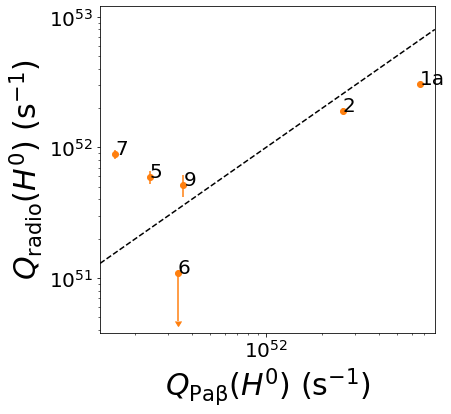

In [17]:
# flux with image smoothed to the 0.201 arcsec in mJy
flux_100GHz = np.array([2.086, 0.988, 1.3, 0.846, 0.39, 0.404, 0.0745, 0.61, 0.355])
flux_100GHz_SC = flux_100GHz[[0,2,5,6,7,8]]
# flux of Paschen beta image in electron/s
# 0.868 is the encircled energy
# 156.97 A is the equivalent width of Pbeta filter
flux_Pbeta = np.array([336, 760, 677, 1356, 220, 73, 44, 74])*photflam/0.868*156.97
# flux_Pbeta_contsub = np.array([237,459,150,133,120,37.9,26.1,49.2])*photflam/0.868*156.97
flux_Pbeta_SC = flux_Pbeta[[0,1,4,5,6,7]]
# continuum subtracted fluxes
flux_Pbeta_SC = np.array([244,521,107,31,20.5,45.6])*photflam/0.868*156.97
print(flux_Pbeta_SC)

Av_SC = np.array([7.3, 3.0, 1.0, 5.0, 4.1, 4.2])
age_SC = np.array([1.0,2.5,1.0,8,3.5,1.0]) # in Myr
APbeta_SC = Av_SC * (1.28/0.551)**(-1.7)
print(APbeta_SC)

# modified equation to calculate APbeta_SC
kv = 2.659*(-2.156+1.509/0.55-0.198/0.55**2+0.011/0.55**3)+4.88
kPbeta = 2.659*(-1.857+1.040/1.28)+4.88
APbeta_SC = Av_SC * kPbeta / kv
print(APbeta_SC)

# Calculate the uncertainties for the radio fluxes
rms = 0.02; pixperbeam = 1.1331*0.21**2/0.015**2
pbValue = np.array([0.85,0.9,1,1,0.95,0.75])
pixNum = np.array([1003, 1933, 1117, 984, 1154, 1529])
flux_100GHz_err = rms / pbValue * np.sqrt(pixNum/pixperbeam)
print(flux_100GHz_err)
rel_err = flux_100GHz_err / flux_100GHz_SC

# set the source 6 to be upper limits
yuplims = np.full(np.shape(flux_100GHz_SC), fill_value=False)
yuplims[3] = True

LPbeta_SC = flux_Pbeta_SC * 10**(0.4*APbeta_SC) * (3.14*(22*3.1e24)**2)
LHalpha_SC = LPbeta_SC * 17.6 
Q_Halpha_SC = LHalpha_SC * 7.4e11
print(Q_Halpha_SC)

L_100GHz_SC = flux_100GHz_SC * 1e-26 * (3.14*(22*3.1e24)**2)
Q_radio_SC = 6.3e25 * 100**0.1 * L_100GHz_SC
print(Q_radio_SC)

region_labels = ['1a','2','5','6','7','9']

fig = plt.figure(figsize=(6,6))

ax = plt.subplot(111)
plt.xscale('log')
plt.yscale('log')
ax.errorbar(Q_Halpha_SC, Q_radio_SC, yerr=Q_radio_SC*rel_err, uplims=yuplims, 
            linestyle='', marker='o', color='tab:orange')

for i, region_label in enumerate(region_labels):
    ax.text(Q_Halpha_SC[i], Q_radio_SC[i], region_label,fontsize=20)
    
ax.set_ylim(top=1.2e53)

lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
ax.plot([lower, upper],[lower,upper],ls='--', color='black')

plt.xlabel(r'$Q_{\mathrm{Pa\beta}}(H^0)$ (s$^{-1}$)', fontsize=30)
plt.ylabel(r'$Q_{\mathrm{radio}}(H^0)$ (s$^{-1}$)', fontsize=30)
ax.tick_params(labelsize = 20)
# fig.tight_layout()
plt.savefig(picDir+'Q_Pbeta_100GHz_contsub.pdf',bbox_inches='tight',pad_inches=0)

#### Optical star clusters from the literature

In [10]:
Q_test = 1.3e13 * LPbeta_SC
print(Q_test)

print(kPbeta/kv)

[9.10058508e+52 3.73350317e+52 4.88512631e+51 7.93369697e+51
 3.34520708e+51 5.85388979e+51]
0.431062269982531
